Tables in dataset 'jdc_data':
 - agg_forecast_sales
 - doorcount
 - filtered_inv
 - filtered_inv_backup
 - filtered_inv_backup2
 - filtered_inv_backup3
 - filtered_inventory
 - filtered_retail_sales
 - filtered_sales
 - forecast_sales
 - inventory
 - sales
 - top11_forecast_sales
  year_month  total_sales
0    2020-01     85951.58
1    2020-02    528272.73
2    2020-03    185643.53
3    2020-04      1655.00
4    2020-05    275650.70


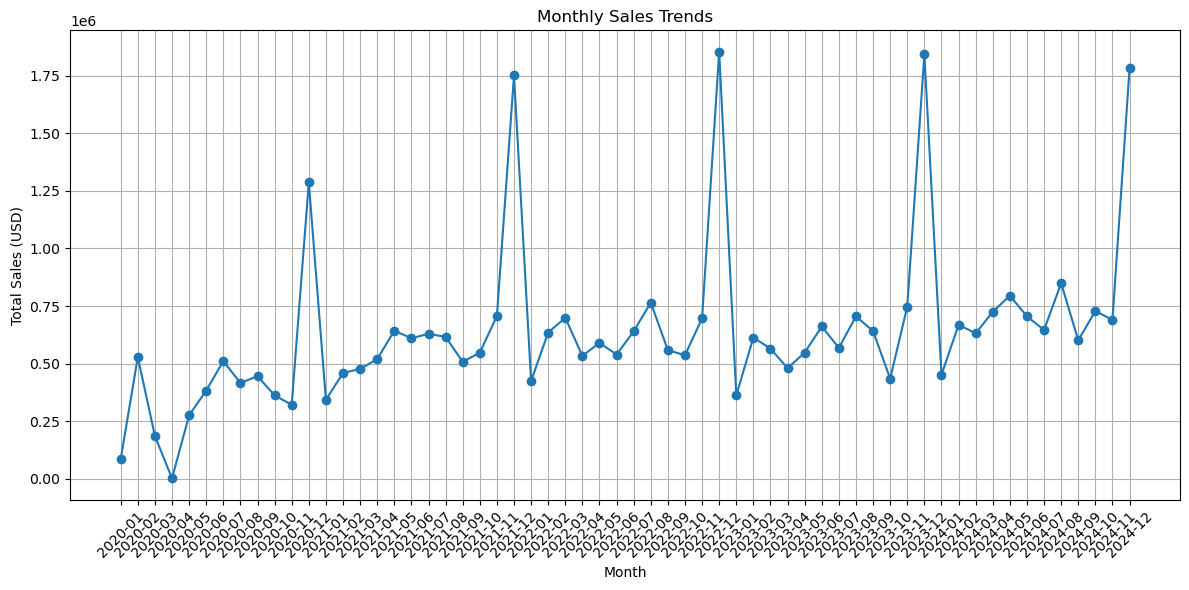

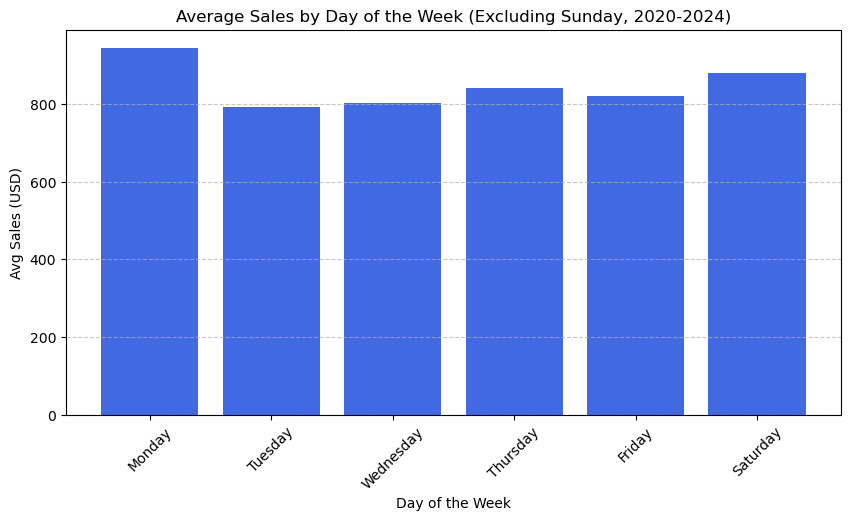

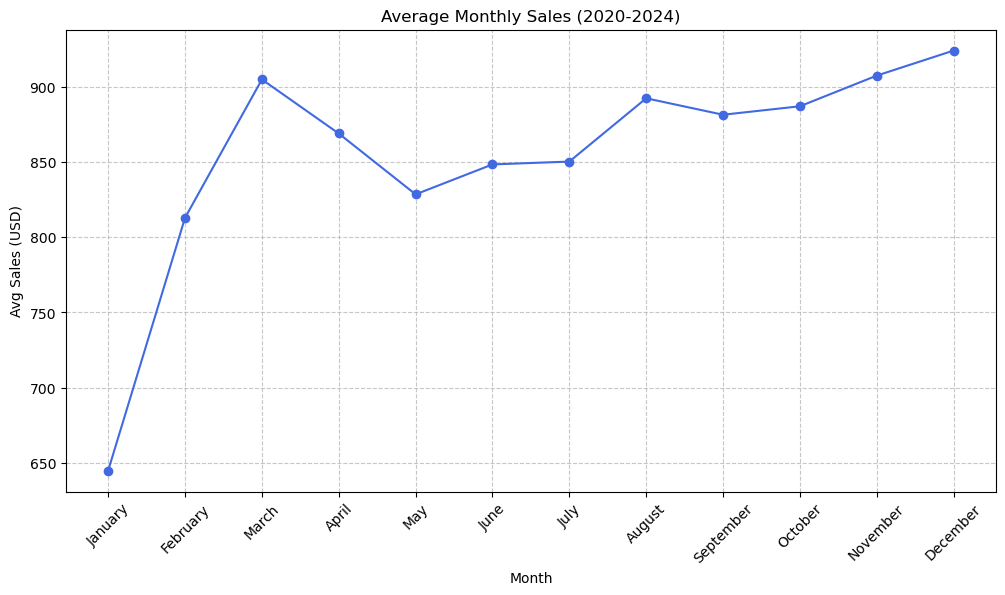

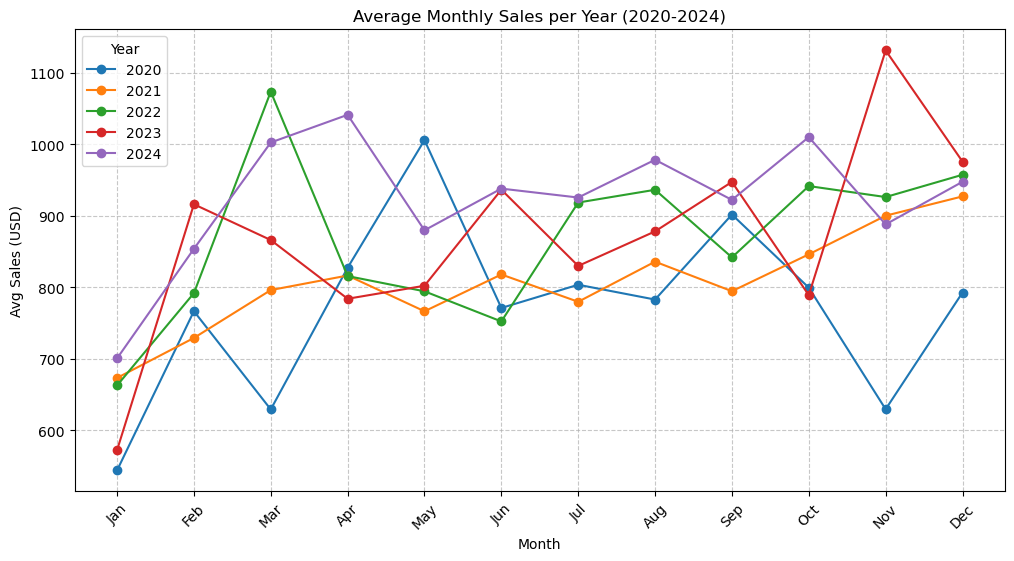

<Figure size 1200x600 with 0 Axes>

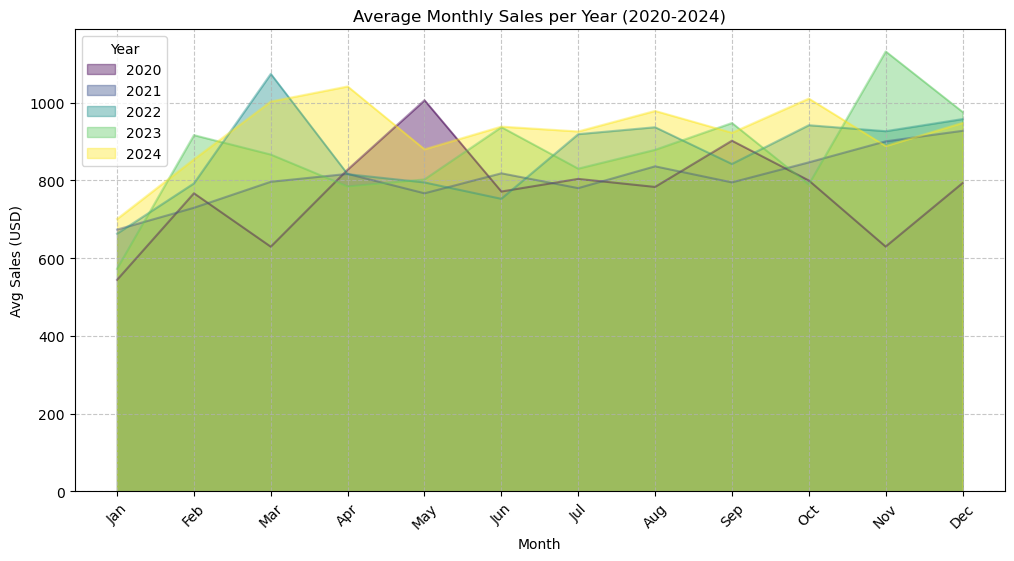

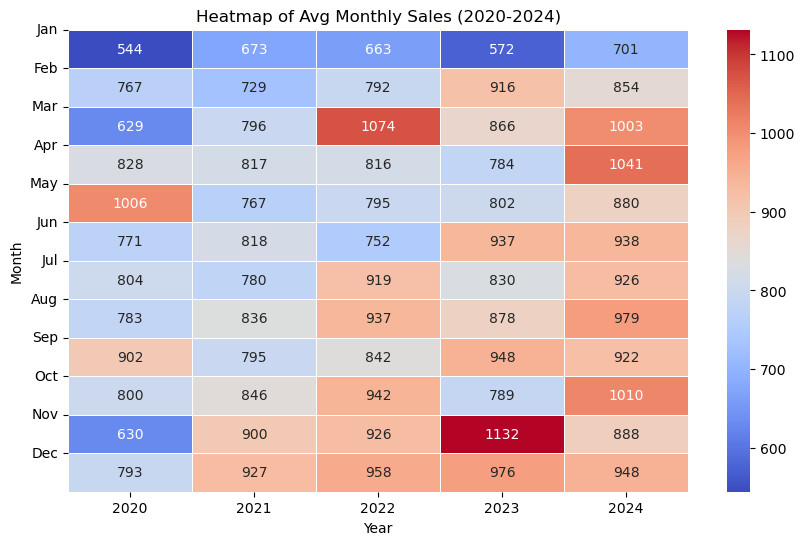

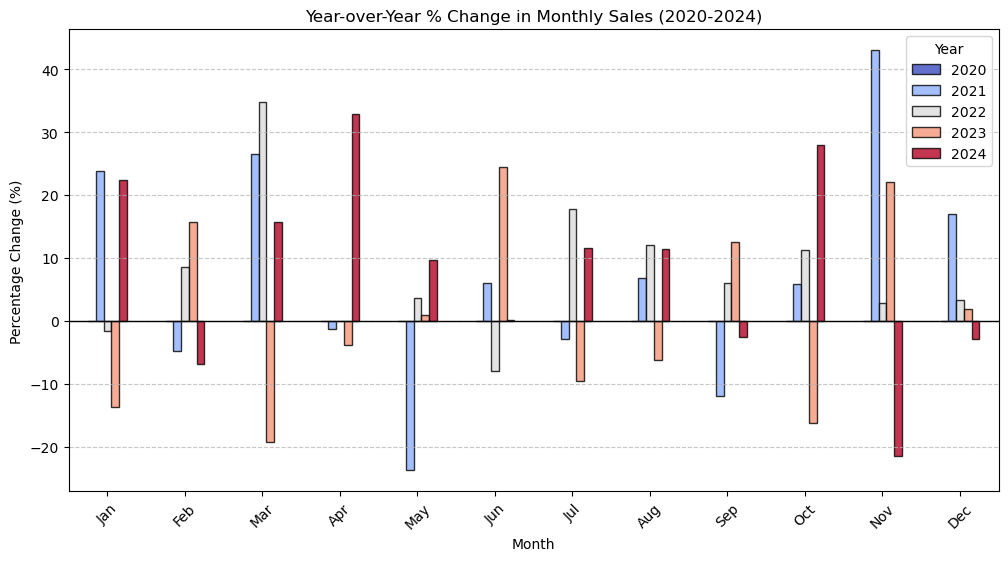

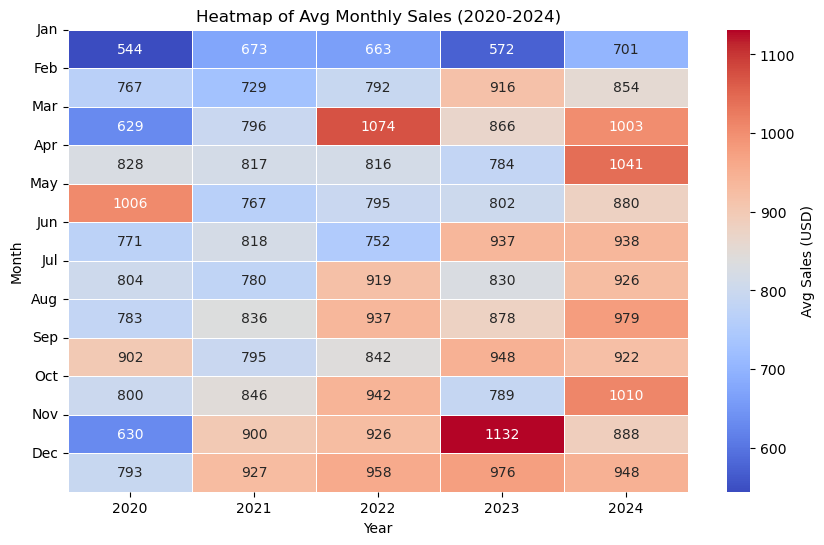

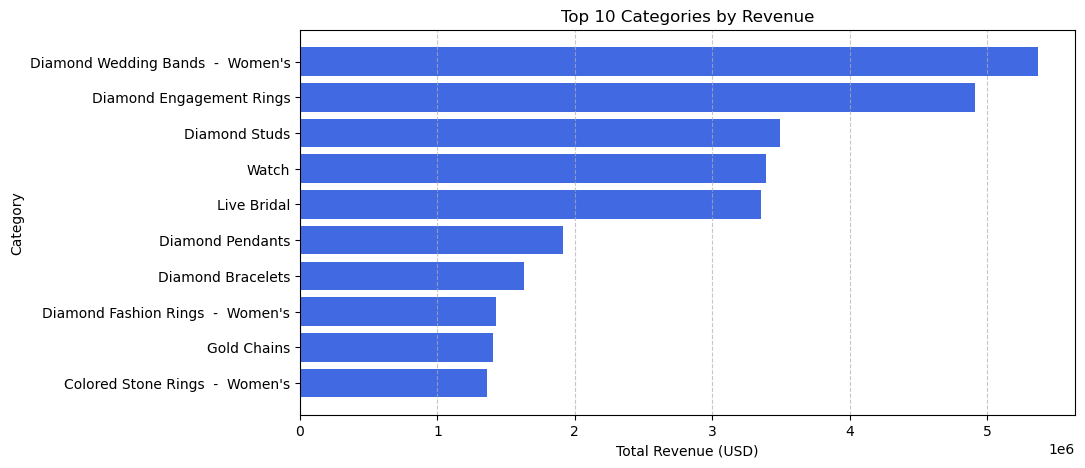

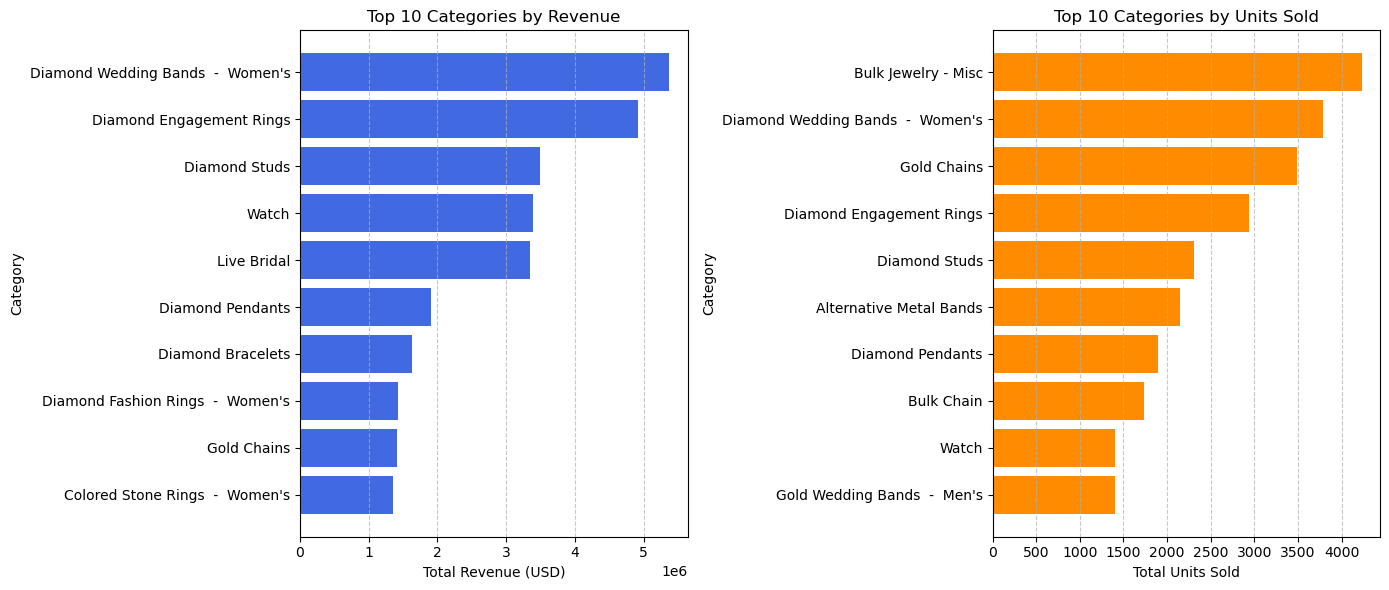

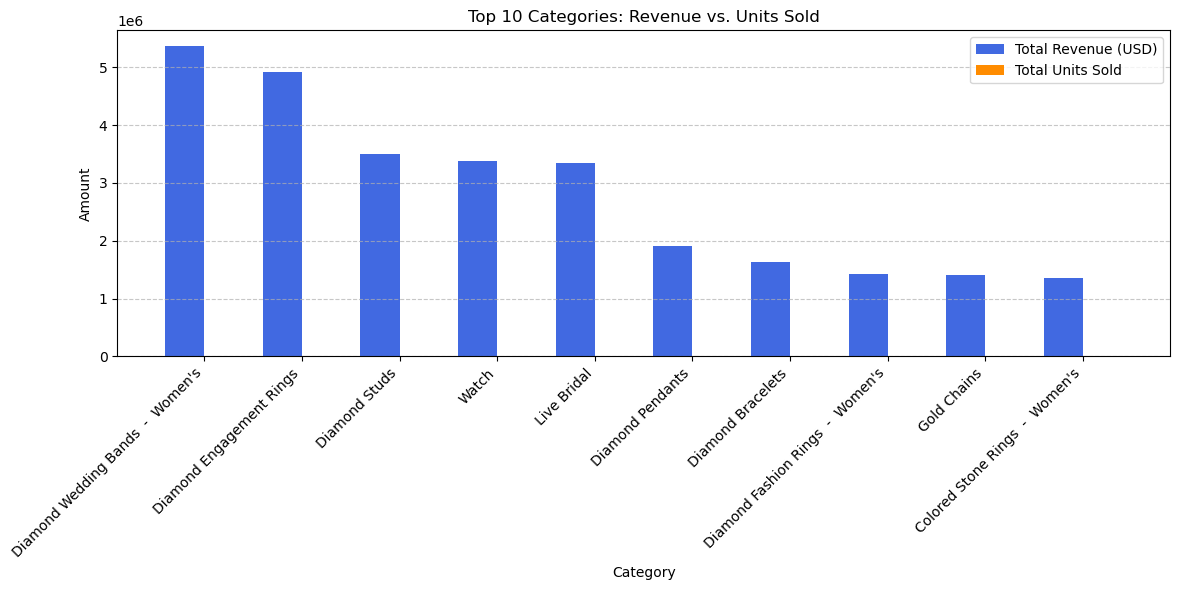

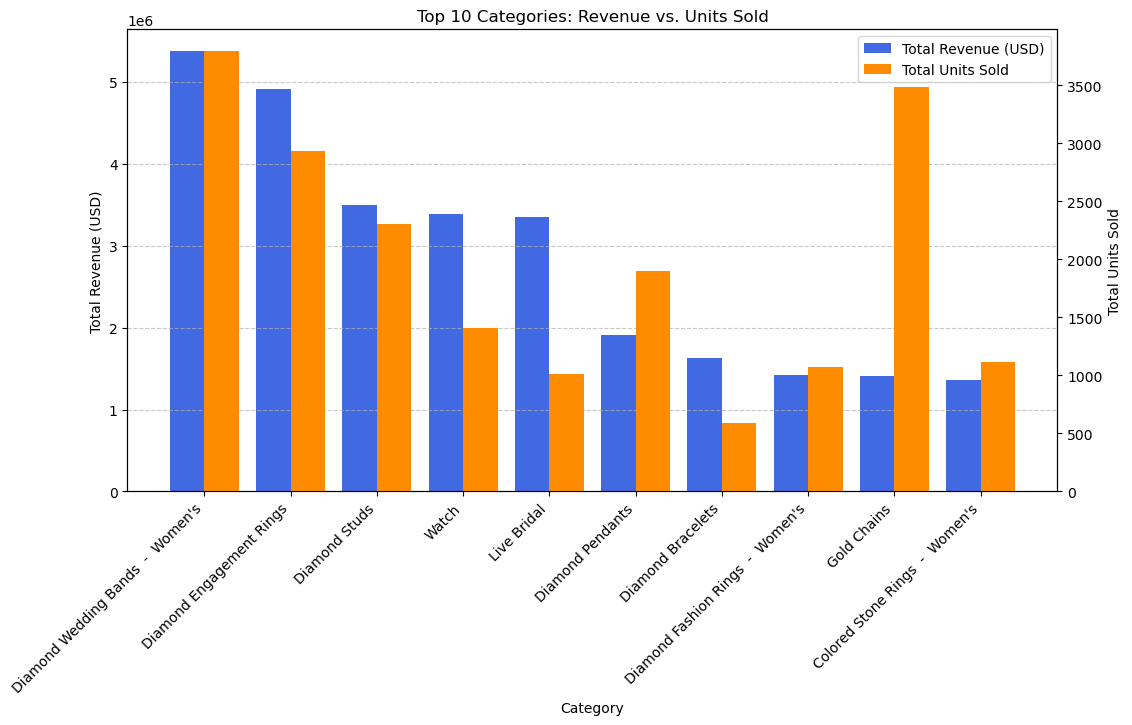

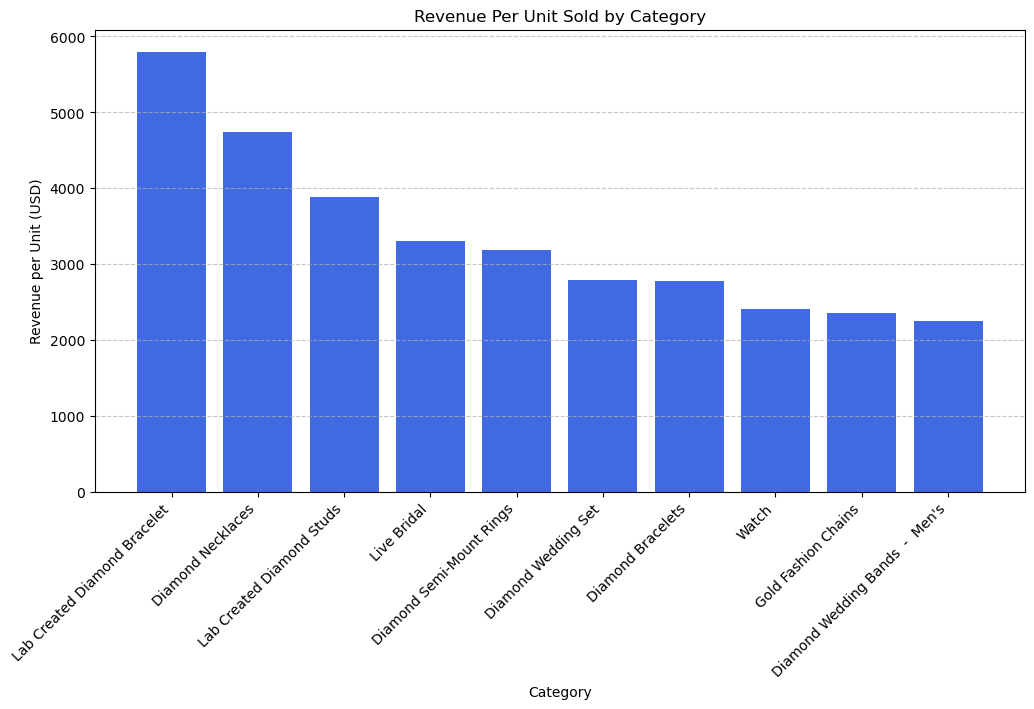

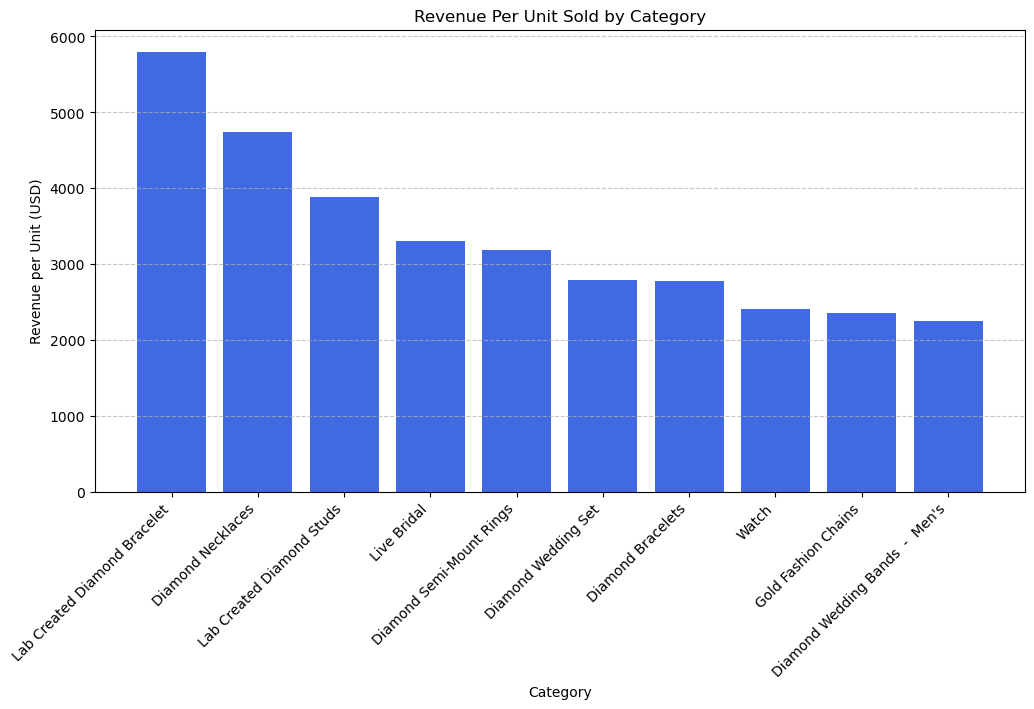

In [1]:
# Initialize BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Set your project ID
project_id = "capstone-project-2025-449217"

# Path to service account key file
key_path = "/Users/juliehilley/Desktop/__Capstone & Prep/capstone-project-2025-449217-f9f34f80492d.json"

# Initialize the BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project=project_id)

# Confirm the connection by listing tables in the jdc_data dataset
dataset_id = "jdc_data"
tables = client.list_tables(dataset_id)
print(f"Tables in dataset '{dataset_id}':")
for table in tables:
    print(f" - {table.table_id}")

# Set the correct table name
table_name = f"{project_id}.{dataset_id}.filtered_retail_sales"

query = f"""
SELECT 
    FORMAT_DATE('%Y-%m', sold_date) AS year_month,
    ROUND(SUM(sale_total), 2) AS total_sales
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY year_month
ORDER BY year_month
"""

# Run the query and store the results in a DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Print the first few rows to confirm data retrieval
print(df.head())

# Plot the time series if data exists
if not df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(df['year_month'], df['total_sales'], marker='o', linestyle='-')
    plt.title('Monthly Sales Trends')
    plt.xlabel('Month')
    plt.ylabel('Total Sales (USD)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No data found for the query.")
    
    
# Query for sales by day of the week (excluding Sunday)
query = f"""
SELECT 
    dayofweek,  
    ROUND(AVG(sale_total), 2) AS average_sales
FROM `{table_name}`
WHERE EXTRACT(YEAR FROM sold_date) BETWEEN 2018 AND 2022
    AND dayofweek != 'Sunday'
GROUP BY dayofweek
ORDER BY 
    CASE 
        WHEN dayofweek = 'Monday' THEN 1
        WHEN dayofweek = 'Tuesday' THEN 2
        WHEN dayofweek = 'Wednesday' THEN 3
        WHEN dayofweek = 'Thursday' THEN 4
        WHEN dayofweek = 'Friday' THEN 5
        WHEN dayofweek = 'Saturday' THEN 6
    END;
"""

# Run the query and store results in a DataFrame
df_weekday = client.query(query).to_dataframe()

# Plot sales by day of the week (excluding Sunday)
plt.figure(figsize=(10, 5))
plt.bar(df_weekday["dayofweek"], df_weekday["average_sales"], color="royalblue")
plt.title("Average Sales by Day of the Week (Excluding Sunday, 2020-2024)")
plt.xlabel("Day of the Week")
plt.ylabel("Avg Sales (USD)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Query BigQuery for monthly sales average over 5 years
query = f"""
SELECT 
    EXTRACT(MONTH FROM sold_date) AS month,
    ROUND(AVG(sale_total), 2) AS avg_monthly_sales
FROM `{table_name}`
WHERE EXTRACT(YEAR FROM sold_date) BETWEEN 2020 AND 2024
GROUP BY month
ORDER BY month;
"""

# Run the query and store results in a DataFrame
df_monthly_sales = client.query(query).to_dataframe()

# Define month labels for readability
month_labels = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_sales["month"], df_monthly_sales["avg_monthly_sales"], marker="o", linestyle="-", color="royalblue")
plt.xticks(ticks=df_monthly_sales["month"], labels=month_labels, rotation=45)
plt.title("Average Monthly Sales (2020-2024)")
plt.xlabel("Month")
plt.ylabel("Avg Sales (USD)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


# Query BigQuery for monthly sales average per year
query = f"""
SELECT 
    EXTRACT(YEAR FROM sold_date) AS year,
    EXTRACT(MONTH FROM sold_date) AS month,
    ROUND(AVG(sale_total), 2) AS avg_monthly_sales
FROM `{table_name}`
WHERE EXTRACT(YEAR FROM sold_date) BETWEEN 2020 AND 2024
GROUP BY year, month
ORDER BY year, month;
"""

# Run the query and store results in a DataFrame
df_monthly_sales = client.query(query).to_dataframe()

# Define month labels for readability
month_labels = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

# Pivot DataFrame to have years as columns and months as index
df_pivot = df_monthly_sales.pivot(index="month", columns="year", values="avg_monthly_sales")

# Plot multi-line chart
plt.figure(figsize=(12, 6))
for year in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[year], marker="o", linestyle="-", label=str(year))

# Formatting
plt.xticks(ticks=range(1, 13), labels=month_labels, rotation=45)
plt.title("Average Monthly Sales per Year (2020-2024)")
plt.xlabel("Month")
plt.ylabel("Avg Sales (USD)")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


#Area Map
plt.figure(figsize=(12, 6))
df_pivot.plot(kind="area", stacked=False, alpha=0.4, figsize=(12, 6), colormap="viridis")

# Formatting
plt.xticks(ticks=range(1, 13), labels=month_labels, rotation=45)
plt.title("Average Monthly Sales per Year (2020-2024)")
plt.xlabel("Month")
plt.ylabel("Avg Sales (USD)")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


# Heat Map - much better viz

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)

# Formatting
plt.title("Heatmap of Avg Monthly Sales (2020-2024)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(ticks=range(12), labels=month_labels, rotation=0)
plt.show()



# Bar Chart showing % Change
df_pivot_pct = df_pivot.pct_change(axis=1) * 100  # Calculate YoY percentage change

df_pivot_pct.plot(kind="bar", figsize=(12, 6), colormap="coolwarm", edgecolor="black", alpha=0.8)

# Formatting
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)
plt.title("Year-over-Year % Change in Monthly Sales (2020-2024)")
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.axhline(0, color="black", linewidth=1)  # Reference line for no change
plt.legend(title="Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()





# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Avg Sales (USD)'})

# Formatting
plt.title("Heatmap of Avg Monthly Sales (2020-2024)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(ticks=range(12), labels=month_labels, rotation=0)
plt.show()


# Query BigQuery for top categories by revenue
query_categories = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

# Fetch data
df_categories = client.query(query_categories).to_dataframe()

# Plot top categories by revenue
plt.figure(figsize=(10, 5))
plt.barh(df_categories["category_name"], df_categories["total_revenue"], color="royalblue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Category")
plt.title("Top 10 Categories by Revenue")
plt.gca().invert_yaxis()  # Highest value on top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()




# Query BigQuery for top categories by revenue
query_revenue = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

# Query BigQuery for top categories by units sold
query_units_sold = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY total_units_sold DESC
LIMIT 10;
"""

# Fetch data
df_revenue = client.query(query_revenue).to_dataframe()
df_units_sold = client.query(query_units_sold).to_dataframe()

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot revenue-based ranking
axes[0].barh(df_revenue["category_name"], df_revenue["total_revenue"], color="royalblue")
axes[0].set_xlabel("Total Revenue (USD)")
axes[0].set_ylabel("Category")
axes[0].set_title("Top 10 Categories by Revenue")
axes[0].invert_yaxis()  # Highest value on top
axes[0].grid(axis="x", linestyle="--", alpha=0.7)

# Plot units-sold-based ranking
axes[1].barh(df_units_sold["category_name"], df_units_sold["total_units_sold"], color="darkorange")
axes[1].set_xlabel("Total Units Sold")
axes[1].set_ylabel("Category")
axes[1].set_title("Top 10 Categories by Units Sold")
axes[1].invert_yaxis()  # Highest value on top
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()



###########################################################################
# Query BigQuery for top categories by revenue
query = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

# Fetch data
df = client.query(query).to_dataframe()

# Define positions for bars
x = np.arange(len(df["category_name"]))  # X-axis positions
width = 0.4  # Bar width

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot revenue bars
bars1 = ax.bar(x - width/2, df["total_revenue"], width, color="royalblue", label="Total Revenue (USD)")

# Plot units sold bars
bars2 = ax.bar(x + width/2, df["total_units_sold"], width, color="darkorange", label="Total Units Sold")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(df["category_name"], rotation=45, ha="right")  # Rotate for readability
ax.set_xlabel("Category")
ax.set_ylabel("Amount")
ax.set_title("Top 10 Categories: Revenue vs. Units Sold")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


# Query BigQuery for top categories by revenue
query = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

# Fetch data
df = client.query(query).to_dataframe()

# Define positions for bars
x = np.arange(len(df["category_name"]))  # X-axis positions
width = 0.4  # Bar width

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot revenue bars (primary y-axis)
bars1 = ax1.bar(x - width/2, df["total_revenue"], width, color="royalblue", label="Total Revenue (USD)")

# Set primary y-axis (Revenue)
ax1.set_xlabel("Category")
ax1.set_ylabel("Total Revenue (USD)")
ax1.set_xticks(x)
ax1.set_xticklabels(df["category_name"], rotation=45, ha="right")  # Rotate for readability
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Create secondary y-axis for units sold
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, df["total_units_sold"], width, color="darkorange", label="Total Units Sold")

# Set secondary y-axis (Units Sold)
ax2.set_ylabel("Total Units Sold")

# Create a combined legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Show plot
plt.title("Top 10 Categories: Revenue vs. Units Sold")
plt.show()


# Query BigQuery for revenue per unit sold
query = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold,
    ROUND(SUM(sale_total) / NULLIF(SUM(qty), 0), 2) AS revenue_per_unit
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY revenue_per_unit DESC
LIMIT 10;
"""

# Fetch data
df = client.query(query).to_dataframe()

# Plot revenue per unit sold
plt.figure(figsize=(12, 6))
plt.bar(df["category_name"], df["revenue_per_unit"], color="royalblue")
plt.xlabel("Category")
plt.ylabel("Revenue per Unit (USD)")
plt.title("Revenue Per Unit Sold by Category")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Revenue Per Unit Sold - Top 10 categories
# Query BigQuery for revenue per unit sold
query = f"""
SELECT 
    category_name,
    ROUND(SUM(sale_total), 2) AS total_revenue,
    SUM(qty) AS total_units_sold,
    ROUND(SUM(sale_total) / NULLIF(SUM(qty), 0), 2) AS revenue_per_unit
FROM `{table_name}`
WHERE sold_date IS NOT NULL
GROUP BY category_name
ORDER BY revenue_per_unit DESC
LIMIT 10;
"""

# Fetch data
df = client.query(query).to_dataframe()

# Plot revenue per unit sold
plt.figure(figsize=(12, 6))
plt.bar(df["category_name"], df["revenue_per_unit"], color="royalblue")
plt.xlabel("Category")
plt.ylabel("Revenue per Unit (USD)")
plt.title("Revenue Per Unit Sold by Category")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Deep Dive into Watches

In [1]:
print(df.columns)


NameError: name 'df' is not defined